# How to install Halotools 

Here is how I installed Halotools on my laptop using `conda`

```
conda create -n halotools python=3.9
conda activate halotools
conda install -c conda-forge halotools
conda install matplotlib jupyter ipython h5py
```

In [ ]:
# Download and cache the halo catalog for later

from halotools.sim_manager import DownloadManager
dman = DownloadManager()
dman.download_processed_halo_table('multidark', 'rockstar', 0.0)

# Exploring the Halo Model

Let us use the `halotools` package (Hearin, et al) to explore the halo model and its behavior. For simplicity, we will use a simple HOD prescription (Zheng et al, 07). 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from halotools.sim_manager import CachedHaloCatalog
from halotools.empirical_models import PrebuiltHodModelFactory

halocat = CachedHaloCatalog(simname='multidark', redshift=0, halo_finder='rockstar')

In [2]:
# Ok, let us now just load in a simple model and look to see what it does
model = PrebuiltHodModelFactory('zheng07', threshold=-21)

In [3]:
# What are the parameters of this model?
print(model.param_dict.keys())
print(model.param_dict.values())

dict_keys(['logMmin', 'sigma_logM', 'logM0', 'logM1', 'alpha'])
dict_values([12.79, 0.39, 11.92, 13.94, 1.15])


In [4]:
# Write a function to plot the HOD of a model
def plot_hod(model):
    halo_mass = np.logspace(10, 15, 1000)
    mean_ncen = model.mean_occupation_centrals(prim_haloprop=halo_mass)
    mean_nsat = model.mean_occupation_satellites(prim_haloprop=halo_mass)
    plt.plot(halo_mass, mean_ncen, label='Centrals')
    plt.plot(halo_mass, mean_nsat, label='Satellites')
    plt.plot(halo_mass, mean_ncen + mean_nsat, label='Total', ls='--')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$M_{\rm halo}$')
    plt.ylim(1e-3, 1e1)
    plt.legend()

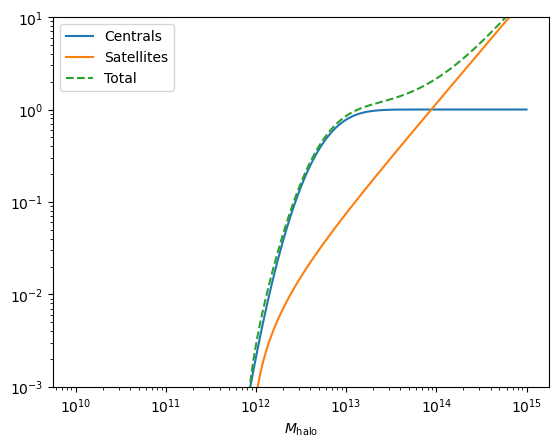

In [5]:
plot_hod(model)

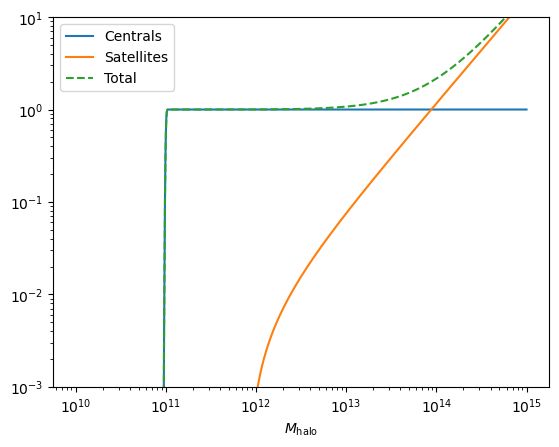

In [6]:
# Try some variations
model.param_dict['logMmin'] = 11.0   # Push to lower masses
model.param_dict['sigma_logM'] = 0.01   # Push to sharper cutoff

plot_hod(model)

In [7]:
from halotools.mock_observables import return_xyz_formatted_array
from halotools.mock_observables import tpcf, tpcf_one_two_halo_decomp

# Take a model and produce a correlation function
def make_clustering(model, maskWith=None):
    rbins = np.logspace(-1, 1.5, 50)
    rbin_centers = (rbins[:-1] + rbins[1:])/2.0

    ret = {}
    ret['r'] = rbin_centers

    model.populate_mock(halocat)
    x = model.mock.galaxy_table['x']
    y = model.mock.galaxy_table['y']
    z = model.mock.galaxy_table['z']
    if maskWith is not None:
        mask = maskWith.apply(model.mock.galaxy_table)
        pos = return_xyz_formatted_array(x, y, z, mask = mask)
        halo_hostid = model.mock.galaxy_table['halo_hostid'][mask]
    else :
        pos = return_xyz_formatted_array(x, y, z)
        halo_hostid = model.mock.galaxy_table['halo_hostid']

    xi_all = tpcf(pos, rbins, period=model.mock.Lbox, num_threads='max')
    ret['xi'] = xi_all

    xi_1h, xi_2h = tpcf_one_two_halo_decomp(pos, halo_hostid, rbins, period=model.mock.Lbox, num_threads='max')
    ret['1h']=xi_1h
    ret['2h']=xi_2h

    return ret


def plot_clustering(ret):
    plt.plot(ret['r'], ret['xi'], label='All')
    plt.plot(ret['r'], ret['1h'], label='1-halo')
    plt.plot(ret['r'], ret['2h'], label='2-halo')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel(r'$r$')
    plt.ylabel(r'$\xi(r)$')
    plt.legend()


{'logMmin': 11.0, 'sigma_logM': 0.01, 'logM0': 11.92, 'logM1': 13.94, 'alpha': 1.15}


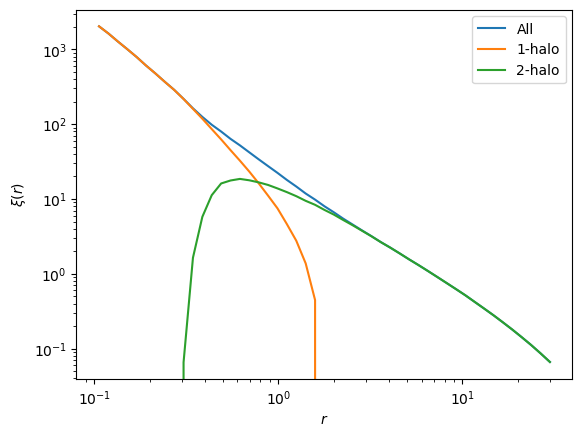

In [8]:
print(model.param_dict)
ret = make_clustering(model)
plot_clustering(ret)

In [9]:
len(model.mock.galaxy_table)

1563578

# Things to try. 

## Clustering as a function of mass, just with centrals


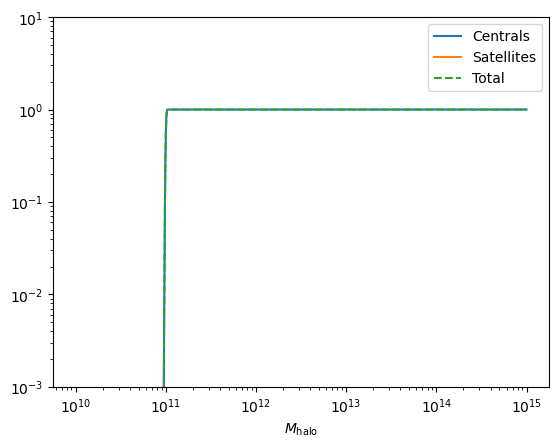

In [29]:
model1 = PrebuiltHodModelFactory('zheng07', threshold=-21) # Just to be safe, let's start from scratch
model1.param_dict['logMmin'] = 11.0
model1.param_dict['sigma_logM'] = 0.01
model1.param_dict['logM0'] = 18.0

plot_hod(model1)

In [10]:
model1 = PrebuiltHodModelFactory('zheng07', threshold=-21) # Just to be safe, let's start from scratch
model1.param_dict['logMmin'] = 11.0
model1.param_dict['sigma_logM'] = 0.01
model1.param_dict['logM0'] = 18.0
ret1 = make_clustering(model1)

model2 = PrebuiltHodModelFactory('zheng07', threshold=-21) # Just to be safe, let's start from scratch
model2.param_dict['logMmin'] = 13.0
model2.param_dict['sigma_logM'] = 0.01
model2.param_dict['logM0'] = 18.0
ret2 = make_clustering(model2)


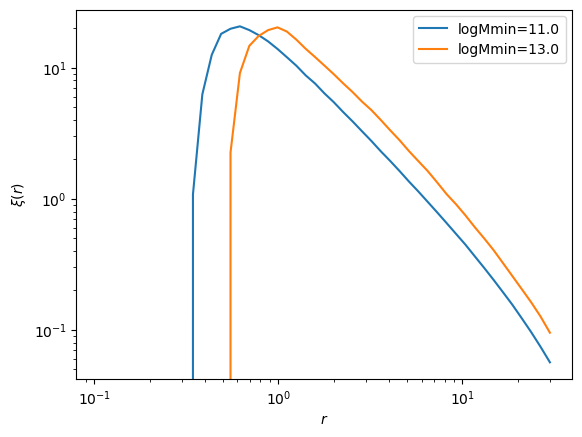

In [11]:
# Plot the results
plt.plot(ret1['r'], ret1['xi'], label='logMmin=11.0')
plt.plot(ret2['r'], ret2['xi'], label='logMmin=13.0')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$r$')
plt.ylabel(r'$\xi(r)$')
plt.legend()

Text(0, 0.5, 'bias')

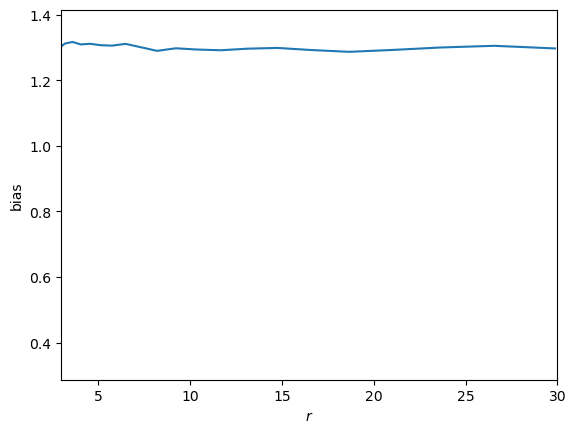

In [13]:
plt.plot(ret1['r'], np.sqrt(ret2['xi']/(ret1['xi']+1e-10)))
plt.xlim(3.0, 30.0)
plt.xlabel(r'$r$')
plt.ylabel('bias')

In [12]:
print(np.mean(model1.mock.galaxy_table['halo_rvir']))
print(np.mean(model2.mock.galaxy_table['halo_rvir']))

0.41386962
0.611227


In [53]:
class MassSlice:
    def __init__(self, massMin, massMax):
        self.massMin = massMin
        self.massMax = massMax
    def apply(self, table):
        logmass = np.log10(table['halo_mvir'])
        return (logmass > self.massMin) & (logmass < self.massMax)

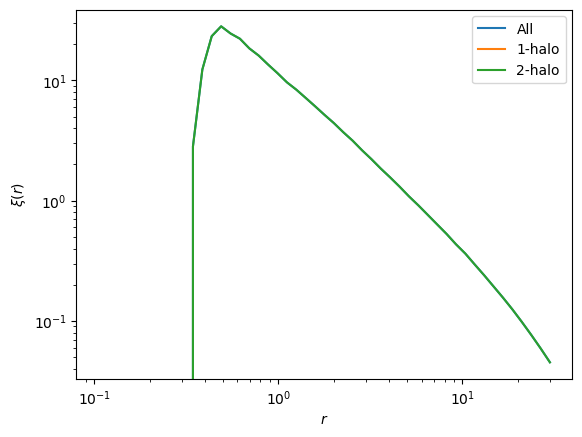

In [57]:
model1 = PrebuiltHodModelFactory('zheng07', threshold=-21) # Just to be safe, let's start from scratch
model1.param_dict['logMmin'] = 11.0
model1.param_dict['sigma_logM'] = 0.01
model1.param_dict['logM0'] = 18.0
slice1 = MassSlice(12.0,13.0)
ret1 = make_clustering(model1, maskWith=slice1)
plot_clustering(ret1)


In [58]:
halocat.keys()

AttributeError: 'CachedHaloCatalog' object has no attribute 'keys'

In [61]:
np.log10(np.min(halocat.halo_table['halo_mvir']))

10.241796